# A Simple Neural Net with Tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

Data shapes:
X: (200, 2)	Y: (200, 1)


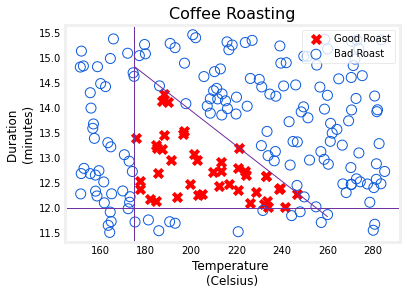

In [3]:
X, Y = load_coffee_data()
print(f"Data shapes:\nX: {X.shape}\tY: {Y.shape}")
plt_roast(X, Y)

Not yet covered, but fitting the weights to the data with back-propagation.
It happens faster with normalized data, as used in course \#1:

In [7]:
# Oh for fuck's sake, this version of tensorflow doesn't have normalization?
# norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
norm_l.adapt(X) # Learn the mean, variance
X_n = norm_l(X)

2022-06-29 20:04:46.817738: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-29 20:04:46.817960: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 20:04:46.818886: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
X_n[:4]

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.83, -0.65],
       [ 1.03, -1.39],
       [ 0.31,  0.87],
       [-1.08, -1.52]], dtype=float32)>

And no idea what tiling is yet, but let's trust in the process for now?
Well, it's tiling like every other sense of the word, but why?
Apparently to increase the training set size, but how does that fuckin' help?
Ooh, reduce the number of training epochs! But it's the same fucking data.

In [9]:
X_t = np.tile(X_n, (1000, 1))
Y_t = np.tile(Y, (1000, 1))
print(X_t.shape, Y_t.shape)

(200000, 2) (200000, 1)


In [11]:
tf.random.set_seed(1234)
# 2 layers, know the input size, though in practice can be ommitted.
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='L1'),
        Dense(1, activation='sigmoid', name='L2')
    ]
)

In [13]:
# Params - for input size 2 and 3 units in L1, 2+1(bias) * 3 = 9
# for 3 units into L2, 3+1 * 1 = 4

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 3)                 9         
_________________________________________________________________
L2 (Dense)                   (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


We expect W1 to have 2x3 shape, features x neurons

We expect W2 to have 3x1 shape,

B1 to be 1x3 and B2 to be 1x1

In [15]:
print([[x.shape for x in model.get_layer(L).get_weights()] for L in ["L1", "L2"]])

[[(2, 3), (3,)], [(3, 1), (1,)]]


More crap that is yet to be explained, and some that has:
- model.compile includes the loss function and compile optimization
- model.fit runs the gradient descent

In [16]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
)

model.fit(X_t, Y_t, epochs=10)

2022-06-29 20:23:52.006581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-29 20:23:52.025518: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3693215000 Hz


Epoch 1/10
6250/6250 [==============================] - 5s 805us/step - loss: 0.2662
Epoch 2/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.1197
Epoch 3/10
6250/6250 [==============================] - 6s 1ms/step - loss: 0.0664
Epoch 4/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0180
Epoch 5/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0115
Epoch 6/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0080
Epoch 7/10
6250/6250 [==============================] - 9s 1ms/step - loss: 0.0056
Epoch 8/10
6250/6250 [==============================] - 9s 2ms/step - loss: 0.0040
Epoch 9/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0029
Epoch 10/10
6250/6250 [==============================] - 9s 1ms/step - loss: 0.0022


That's a spicy meatball. Finally (and boy did it take a while) the weights are updated to minimize loss.

In [18]:
W1, b1 = model.get_layer("L1").get_weights()
W2, b2 = model.get_layer("L2").get_weights()
print(f"W1:\n{W1}\nb1: {b1}\nW2:\n{W2}\nb2: {b2}")

W1:
[[ -0.13  14.3  -11.1 ]
 [ -8.92  11.85  -0.25]]
b1: [-11.16   1.76 -12.1 ]
W2:
[[-45.71]
 [-42.95]
 [-50.19]]
b2: [26.14]


Time to predict.

Remember, we normalized the training data, so we must normalize anything we want to predict.

In [19]:
X_test = norm_l(
    np.array([
        [200, 13.9],
        [200, 17]
    ])
)

predictions = model.predict(X_test)
print(f"Predictions:\n{predictions}")

Predictions:
[[9.89e-01]
 [4.94e-08]]


First example is 98.9% (Good) and the second is almost 0 (Bad)

So let's threshold it:

In [26]:
# bool version
# y_hat = predictions >= 0.5
# int version
# y_hat = np.int32(predictions >= 0.5)
# or
y_hat = (predictions >= 0.5).astype(int)
print(y_hat)

[[1]
 [0]]


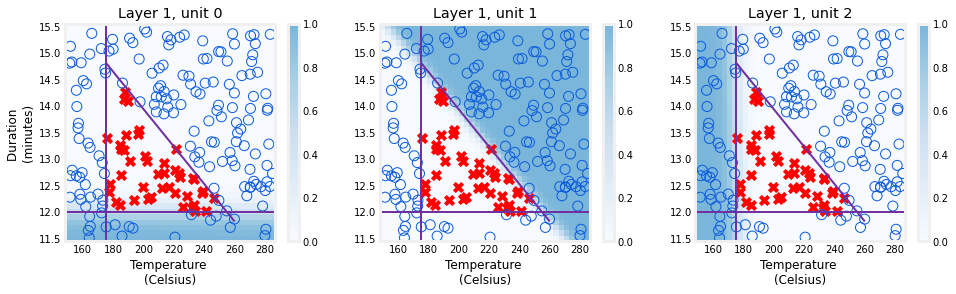

In [27]:
plt_layer(X, Y.reshape(-1,), W1, b1, norm_l)

Looking at the above, using magic background functions, we can see that

each neuron in the first layer appears to be responsible for one region of

the bad examples, or the factors that contribute to a bad roast.

First: Low duration. Second: High duration/temperature combo. Third: Low temperature.

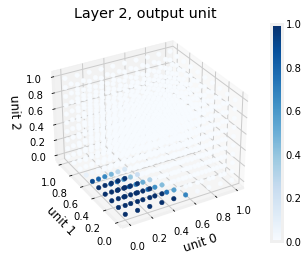

In [28]:
plt_output_unit(W2, b2)

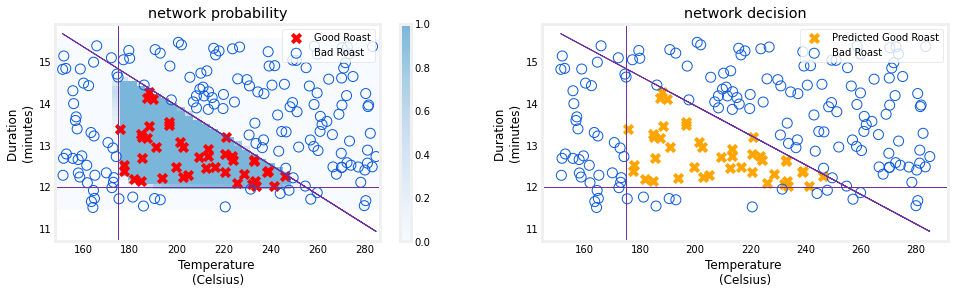

In [29]:
netf = lambda x : model.predict(norm_l(x))
plt_network(X, Y, netf)